In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
cd ../gdrive/My\ Drive/Colab\ Notebooks/Graph\ Curvature\ Networks

/gdrive/My Drive/Colab Notebooks/Graph Curvature Networks


In [4]:
# colab setting
!pip install GraphRicciCurvature
!pip install grakel

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool
import networkx as nx
import numpy as np
import math
import os
import importlib
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import pandas as pd
from collections import defaultdict


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm_notebook

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
clear_output()

In [5]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric
clear_output()

In [6]:
def make_data(G, y):
    x = from_networkx(G)
    x.y = y 
    return x

In [38]:
# from http://www3.cs.stonybrook.edu/~chni/
def FormannCurvature(G, weighted=False, EPS=1e-15, default_node_curvature=None):
    G = G.copy()
    for (v1, v2) in G.edges():
        if not weighted:
            if G.is_directed():
                v1_nbr = set(list(G.predecessors(v1)) + list(G.successors(v1)))
                v2_nbr = set(list(G.predecessors(v2)) + list(G.successors(v2)))
            else:
                v1_nbr = set(G.neighbors(v1))
                v1_nbr.remove(v2)
                v2_nbr = set(G.neighbors(v2))
                v2_nbr.remove(v1)
            face = v1_nbr & v2_nbr
            prl_nbr = (v1_nbr | v2_nbr) - face
            G[v1][v2]["formanCurvature"] = len(face) + 2 - len(prl_nbr)
        else:
            w_e = G[v1][v2]['weight'] + np.sqrt(EPS)
            w_i = 1.
            w_j = 1.
            S_i = sum([w_i/np.sqrt(v['weight']*w_e + EPS) if k!=v2 else 0. \
                       for k,v in G[v1].items()])
            S_j = sum([w_j/np.sqrt(v['weight']*w_e + EPS) if k!=v1 else 0. \
                      for k,v in G[v2].items()])
            curv = w_e*( (w_i/w_e) + (w_j/w_e) - S_i - S_j)
            G[v1][v2]["formanCurvature"] = curv
            assert not np.isnan(curv).any()

    # Node Forman curvature
    for n in G.nodes():
        fcsum = 0  # sum of the neighbor Forman curvature
        if G.degree(n) != 0:
            for nbr in G.neighbors(n):
                if 'formanCurvature' in G[n][nbr]:
                    fcsum += G[n][nbr]['formanCurvature']
            # assign the node Forman curvature to be the average of node's adjacency edges
            G.nodes[n]['formanCurvature'] = fcsum / G.degree(n)
        else:
            G.nodes[n]['formanCurvature'] = default_node_curvature

                
    return G

# CurvConv architecture

In [39]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid, Amazon, Coauthor

from torch_geometric.nn import MessagePassing, GlobalAttention, GCNConv 
from torch_geometric.nn import EdgeConv, ECConv
from torch.nn import LeakyReLU,init,Linear, Sequential

from torch_geometric.utils import softmax, degree, add_self_loops, remove_self_loops
from torch_geometric.utils.convert import from_networkx, to_networkx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_=torch.manual_seed(42)

In [40]:
################################
# DEFINE CURVATURE CONVOLUTION #
################################
class curvGN(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim=1, bias=True):
        super(curvGN, self).__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        widths = [edge_dim, out_channels]
        self.w_mlp_out = create_wmlp(widths, out_channels, True)

    def forward(self, x, edge_index, w_mul):
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        out_weight = self.w_mlp_out(w_mul)
        out_weight = softmax(out_weight, edge_index[0])

        return self.propagate(edge_index,  x=x, out_weight=out_weight), out_weight

    def message(self, x_j, out_weight):
        return out_weight*x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 5: Return new node embeddings.
        return aggr_out

def create_wmlp(widths, nfeato, lbias):
    mlp_modules=[]
    for k in range(len(widths)-1):
        mlp_modules.append(Linear(widths[k], widths[k+1], bias=False))
        mlp_modules.append(LeakyReLU(0.2, True))
    mlp_modules.append(Linear(widths[len(widths)-1], nfeato, bias=lbias))

    return Sequential(*mlp_modules)


In [80]:
###################
# DEFINE NETWORKS #
###################
class NetСurvWithReadout(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64, edge_dim=1, use_dropout=True):

        super(NetСurvWithReadout, self).__init__()
        self.use_dropout = use_dropout
        self.conv1 = curvGN(num_features, hidden, edge_dim=edge_dim)
        # self.conv2 = curvGN(hidden, hidden, edge_dim=edge_dim)
        # self.conv3 = curvGN(hidden, hidden, edge_dim=edge_dim)
        self.conv4 = curvGN(hidden, hidden, edge_dim=edge_dim)
        self.global_attention = GlobalAttention(gate_nn=nn.Linear(hidden,1), 
                                                nn=nn.Linear(hidden,hidden))
        self.linear = nn.Linear(hidden,num_classes)

        self.bn1 = nn.BatchNorm1d(num_features)
        # self.bn2 = nn.BatchNorm1d(hidden)
        # self.bn3 = nn.BatchNorm1d(hidden)
        self.bn4 = nn.BatchNorm1d(hidden)
        self.bn_w = nn.BatchNorm1d(edge_dim)

    def forward(self, data):
        x, edge_index, batch, w_mul = data.x, data.edge_index, data.batch, data.edge_attr
        
        w_mul = self.bn_w(w_mul)
        x = self.bn1(x)
        x, _ = self.conv1(x, edge_index, w_mul)
        x = F.elu(x)

        # x = self.bn2(x)
        # x, _ = self.conv2(x, edge_index, w_mul)
        # x = F.elu(x)

        if self.use_dropout:
            x = F.dropout(x, training=self.training)

        # x = self.bn3(x)
        # x, _ = self.conv3(x, edge_index, w_mul)
        # x = F.elu(x)

        x = self.bn4(x)
        x, _ = self.conv4(x, edge_index, w_mul)
        x = F.elu(x)

        #readout
        readout = self.global_attention(x, batch) 
        x = self.linear(readout)

        return F.log_softmax(x, dim=-1)

class NetWithReadout(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64, use_dropout=True):
        super(NetWithReadout, self).__init__()

        self.use_dropout = use_dropout
        self.conv1 = GCNConv(num_features, hidden)
        # self.conv2 = GCNConv(hidden, hidden)
        # self.conv3 = GCNConv(hidden, hidden)
        self.conv4 = GCNConv(hidden, hidden)
        self.global_attention = GlobalAttention(gate_nn=nn.Linear(hidden,1), 
                                                nn=nn.Linear(hidden,hidden))
        self.linear = nn.Linear(hidden,num_classes)
        self.bn1 = nn.BatchNorm1d(num_features)
        # self.bn2 = nn.BatchNorm1d(hidden)
        # self.bn3 = nn.BatchNorm1d(hidden)
        self.bn4 = nn.BatchNorm1d(hidden)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.bn1(x)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        # x = self.bn2(x)
        # x = self.conv2(x, edge_index)
        # x = F.elu(x)

        if self.use_dropout:
            x = F.dropout(x, training=self.training)

        # x = self.bn3(x)
        # x = self.conv3(x, edge_index)
        # x = F.elu(x)

        x = self.bn4(x)
        x = self.conv4(x, edge_index)
        x = F.elu(x)

        #readout
        readout = self.global_attention(x, batch) 
        x = self.linear(readout)

        return F.log_softmax(x, dim=-1)
    

## Training

In [81]:
def validate_model(model,
                   dataloader):
  

    loss_history = []
    acc_history = []
    for i, batch in enumerate(dataloader):
            batch = batch.to(device)
            model.eval()
            out = model(batch)

            target = torch.LongTensor(batch.y).to(device)
            loss = F.nll_loss(out, target) 
            loss_history.append(loss.item())
            acc = (out.argmax(-1) == target).sum() / float(len(target))
            acc_history.append(acc.item())

    # end of the epoch
    history_loss = np.mean(loss_history)
    history_acc = np.mean(acc_history)

    return history_loss, history_acc


def train_model(model, 
                dataloader,
                n_epochs=150):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

    history_acc = defaultdict(list)
    history_loss = defaultdict(list)
    
    for epoch in tqdm_notebook(range(n_epochs)):
        loss_history = []
        acc_history = []
        model.train()
        for i, batch in enumerate(dataloader):

            batch = batch.to(device)
            model.train()
            optimizer.zero_grad()
            out = model(batch)

            target = torch.LongTensor(batch.y).to(device)
            loss = F.nll_loss(out, target) 
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            acc = (out.argmax(-1) == target).sum() / float(len(target))
            acc_history.append(acc.item())

        # end of the epoch
        history_loss['epoch'].append(np.mean(loss_history))
        history_loss['all'] += loss_history
        history_acc['epoch'].append(np.mean(acc_history))
        history_acc['all'] += acc_history

        # model.eval()
        # pred = out/
        # _, pred = pred.max(dim=1)
        # y_pred = pred[data.test_mask].detach().cpu().numpy()
        # y_true = data.y[data.test_mask].detach().cpu().numpy()
        # # correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        # acc = f1_metric(y_true, y_pred)
        # # acc = correct / data.test_mask.sum().item()
        # acc_history.append(acc)

    return history_loss, history_acc

# Graph classification: MUTAG

In [ ]:
import grakel
from grakel import GraphKernel
from grakel.kernels import VertexHistogram, ShortestPath, WeisfeilerLehman, EdgeHistogram, CoreFramework, PropagationAttr
from grakel.datasets import fetch_dataset

mutag = fetch_dataset("MUTAG", verbose=False, as_graphs=False)
mutag_G = fetch_dataset("MUTAG", verbose=False, as_graphs=True)
X_mutag, y_mutag = mutag.data, mutag.target
y_mutag.shape

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


(188,)

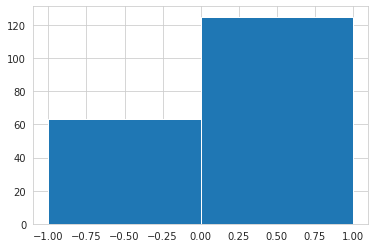

In [ ]:
num_classes = len(np.unique(y_mutag))
plt.hist(y_mutag,bins=num_classes)
plt.show()
y = y_mutag.copy()
y[y == -1] = 0

In [ ]:
edges_types = []
nodes_types = []
for _,nodes, edges_labels in X_mutag:
    nodes_types += list(nodes.values())
    edges_types += list(edges_labels.values())

n_nodes_types = len(np.unique(nodes_types))
n_edges_types = len(np.unique(edges_types))

node2index = dict(zip(np.arange(n_nodes_types), 
                      np.unique(nodes_types)))
edge2index = dict(zip(np.arange(n_edges_types), 
                      np.unique(edges_types)))

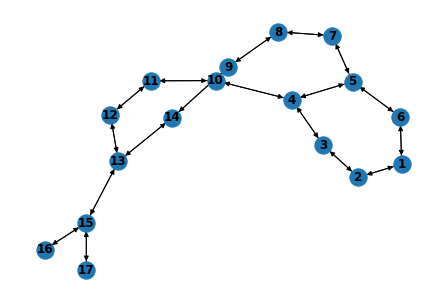

In [ ]:
def one_hot(x, mapping):
    return np.eye(n_nodes_types)[node2index[x]].tolist()

X_mutag_nx = []
for (edges, nodes, edges_labels) in X_mutag: 
    g = nx.DiGraph()
    
    combined_nodes_list = [(node, {'x':one_hot(nodes[node], mapping=node2index)}) for node in nodes] 
    g.add_nodes_from(combined_nodes_list)

    combined_edges_list = [(edge[0], edge[1], {'edge_attr': one_hot(edges_labels[edge], mapping=edge2index)}) for edge in edges] 
    g.add_edges_from(combined_edges_list)
    
    X_mutag_nx.append(g)
nx.draw(X_mutag_nx[0], with_labels=True, font_weight='bold')

In [ ]:
g_nx = X_mutag_nx[0]
g_nx.number_of_edges()

38

In [ ]:
g_gk = mutag_G.data[0]
len(g_gk.get_edges())

38

In [ ]:
edges_curvatures = defaultdict(list)
nodes_curvatures = defaultdict(list)

for data_nx in tqdm_notebook(X_mutag_nx):
    weighted_edges = False 

    orc = OllivierRicci(data_nx,  alpha=0.5, verbose="ERROR", nbr_topk=100)
    _ = orc.compute_ricci_curvature()
    G_orc = orc.G.copy()
    try:
        ricci_curvatures_olliver = {(v1,v2):G_orc[v1][v2]['ricciCurvature'] for v1,v2 in list(G_orc.edges)}
        ricci_curvatures_olliver_nodes = {i:G_orc.nodes[i]['ricciCurvature'] for i in list(G_orc.nodes)}
      
        G_frc = FormannCurvature(data_nx, weighted=weighted_edges)
        ricci_curvatures_formann = {(v1,v2):G_frc[v1][v2]['formanCurvature'] for v1,v2 in list(G_frc.edges)}
        ricci_curvatures_formann_nodes = {i:G_frc.nodes[i]['formanCurvature'] for i in list(G_frc.nodes)} 
    except:
        set_trace()

    edges_curvatures['Olliver'].append(ricci_curvatures_olliver)
    edges_curvatures['Formann'].append(ricci_curvatures_formann)

    nodes_curvatures['Olliver'].append(ricci_curvatures_olliver_nodes)
    nodes_curvatures['Formann'].append(ricci_curvatures_formann_nodes)

    # edges_weights =  nx.get_edge_attributes(data_nx, "weight")
clear_output()    

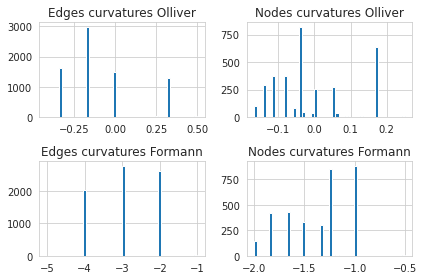

In [ ]:
fig, axes = plt.subplots(ncols = 2, nrows=2)

curvature_types = ['Olliver', 'Formann']
for i,curvature_type in enumerate(curvature_types):
  all_edges_curvatures = []
  all_nodes_curvatures = []
  for (graph_curvs, nodes_curvs) in zip(edges_curvatures[curvature_type], 
                                      nodes_curvatures[curvature_type]):
      all_edges_curvatures += list(graph_curvs.values())
      all_nodes_curvatures += list(nodes_curvs.values())
  
  axes[i,0].hist(all_edges_curvatures,bins=50)
  axes[i,0].set_title(f'Edges curvatures {curvature_type}')
  axes[i,1].hist(all_nodes_curvatures,bins=50)
  axes[i,1].set_title(f'Nodes curvatures {curvature_type}')

plt.tight_layout()
plt.show()

In [ ]:
# with both edge an nodes curvatures
X_mutag_nx_node_curvature = []
for i,graph in enumerate(X_mutag_nx):
    g = graph.copy()
    for edge in g.edges:
        one_hot_labels = g[edge[0]][edge[1]]['edge_attr']
        g[edge[0]][edge[1]]['edge_attr'] = one_hot_labels + [np.float(edges_curvatures['Olliver'][i][edge])]
    for node in g.nodes:
        one_hot_labels = g.nodes[node]['x']
        g.nodes[node]['x'] = one_hot_labels + [np.float(nodes_curvatures['Olliver'][i][node]),
                                               np.float(nodes_curvatures['Formann'][i][node])]    
    X_mutag_nx_node_curvature.append(g)      

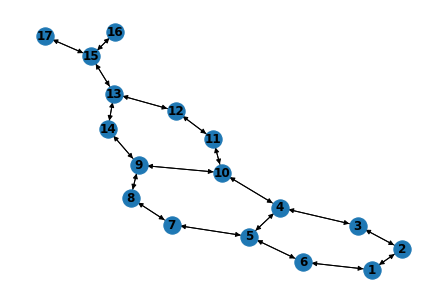

In [ ]:
g_nx_c = X_mutag_nx_node_curvature[0]
nx.draw(g_nx_c, with_labels=True, font_weight='bold')

In [ ]:
data_mutag = [make_data(G,y) for G,y in zip(X_mutag_nx, y)]
data_mutag_node_curv = [make_data(G,y) for G,y in zip(X_mutag_nx_node_curvature, y)]

In [ ]:
dataloader = DataLoader(data_mutag, batch_size=32)
dataloader_node_curv = DataLoader(data_mutag_node_curv, batch_size=32)

In [ ]:
for batch in dataloader:
    break
for batch_curv in dataloader_node_curv:
    break

In [ ]:
net = NetWithReadout(num_features=batch.x.shape[-1], 
                     num_classes=num_classes, 
                     hidden=64).to(device)
history_loss_baseline, history_acc_baseline = train_model(net, 
                                                          dataloader, 
                                                          n_epochs=120)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
curv_net = NetСurvWithReadout(num_features=batch_curv.x.shape[-1], 
                              num_classes=num_classes, 
                              edge_dim=batch_curv.edge_attr.shape[-1], 
                              hidden=64).to(device)
history_loss_curv, history_acc_curv = train_model(curv_net, 
                                                  dataloader_node_curv,
                                                  n_epochs=120)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


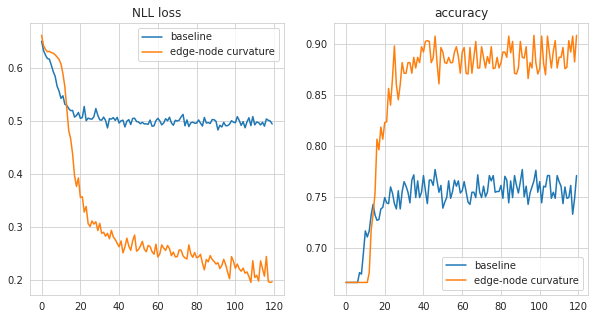

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

history_loss_baseline, 

history_acc_baseline

ax1.plot(history_loss_baseline['epoch'], label = 'baseline')
ax1.plot(history_loss_curv['epoch'], label = 'edge-node curvature')
ax1.set_title('NLL loss')

ax2.plot(history_acc_baseline['epoch'], label = 'baseline')
ax2.plot(history_acc_curv['epoch'], label = 'edge-node curvature')
ax2.set_title('accuracy')

ax1.legend()
ax2.legend()
plt.show()

# ABIDE-1

In [18]:
def get_curvatures(data_nx, weighted_edges = False, compute_olliver=False):
    
    results = defaultdict(dict)

    if compute_olliver:
        orc = OllivierRicci(data_nx, alpha=0.5, verbose='INFO', nbr_topk=10)
        _ = orc.compute_ricci_curvature()
        G_orc = orc.G.copy()
        try:
            ricci_curvatures_olliver = {(v1,v2):G_orc[v1][v2]['ricciCurvature'] for v1,v2 in list(G_orc.edges)}
            ricci_curvatures_olliver_nodes = {i:G_orc.nodes[i]['ricciCurvature'] if hasattr(G_orc.nodes[i],'ricciCurvature') else 1e-15 for i in list(G_orc.nodes)} 
        except:
            set_trace()
        results['Olliver']['edges'] = ricci_curvatures_olliver
        results['Olliver']['nodes'] = ricci_curvatures_olliver_nodes

    G_frc = FormannCurvature(data_nx, weighted=weighted_edges, default_node_curvature=3)
    ricci_curvatures_formann = {(v1,v2):G_frc[v1][v2]['formanCurvature'] for v1,v2 in list(G_frc.edges)}
    ricci_curvatures_formann_nodes = {i:G_frc.nodes[i]['formanCurvature'] for i in list(G_frc.nodes)}

    results['Formann']['edges'] = ricci_curvatures_formann
    results['Formann']['nodes'] = ricci_curvatures_formann_nodes

    clear_output() 

    return results

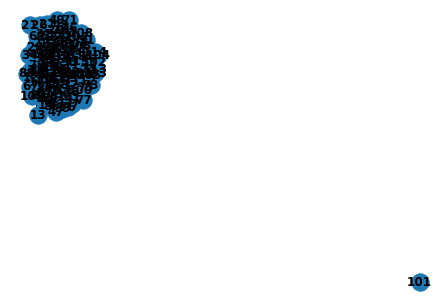

In [21]:
def threshold_matrix(corr_matrix, threshold=0.5):
      A = corr_matrix.copy()
      A = np.abs(A)
      A[A < threshold] = 0
      return A
corr_matrix = np.load('./ABIDE1/ABIDE1_AAL.npy')[0]
corr_matrix = threshold_matrix(corr_matrix, threshold=0.2)
E = np.eye(corr_matrix.shape[0])
g = nx.from_numpy_matrix(corr_matrix-E)
nx.draw(g, with_labels=True, font_weight='bold')

In [64]:
from sklearn.model_selection import train_test_split
from copy import deepcopy

class ABIDEDataset(Dataset):
    def __init__(self, 
                 numpy_data_folder='ABIDE', 
                 numpy_target_path='ABIDE1/target.npy', 
                 atlas_type='AAL', 
                 threshold=None, 
                 rebuild=True,
                 compute_olliver=True,
                 curvatures_path=None):
      
        super(ABIDEDataset, self).__init__()

        self.numpy_data = np.load(f'{numpy_data_folder}/ABIDE1_{atlas_type}.npy')
        self.numpy_target = np.load(numpy_target_path)
        self.threshold = threshold
        self.curvatures_path = curvatures_path
        self.compute_olliver = compute_olliver
        self.rebuild = rebuild
        N = self.numpy_data.shape[0]

        self.dirname = f'ABIDE_torch_geom_data_{atlas_type}' +\
                       (f'_thresh-{self.threshold}' if self.threshold is not None else '') +\
                       'curv_formann' +\
                       ('_olliver' if compute_olliver else '')

        if (not os.path.isdir(self.dirname)) or len(os.listdir(self.dirname))!=N or self.rebuild:
            self.N = self.numpy_data.shape[-1]
            print (f'Making pytorch-data directory: `{self.dirname}`')
            os.makedirs(self.dirname, exist_ok=True)

            if self.curvatures_path is not None:
                print ('Load pre-computed curvatures...')
                self.curv_abide = np.load(self.curvatures_path, allow_pickle=True).tolist()
          
            pool = ThreadPool(mp.cpu_count())
            _ = pool.map(self.make_item, range(N))
            pool.close()
            pool.join()
        
        print ('Done!')
        self.items = [os.path.join(self.dirname, data_name) for data_name in sorted(os.listdir(self.dirname))]
        assert len(self.items) > 0

    def split(self):
        # split the data to train\val datasets
        train_items, val_items = train_test_split(self.items, shuffle=True, random_state =42)
        self_train = deepcopy(self)
        self_train.items = train_items
        self_val = deepcopy(self)
        self_val.items = val_items

        return self_train, self_val

    def make_item(self, i):

        item_name = os.path.join(self.dirname,'data_%06d'%i)

        if not os.path.isfile(item_name) or self.rebuild:
            corr_matrix = self.numpy_data[i]
            target = self.numpy_target[i]
            # eliminate self-corellation
            corr_matrix = corr_matrix-np.diag(corr_matrix.diagonal())
            if self.threshold is not None:
                corr_matrix = self.threshold_matrix(corr_matrix)
            # make graph
            g = nx.from_numpy_matrix(corr_matrix)
            g_uniform = g.copy()
            nx.set_edge_attributes(g_uniform, 1., 'weight')

            if self.curvatures_path is None:
                curvature = get_curvatures(g_uniform, compute_olliver=self.compute_olliver)
            else:
                curvature = self.curv_abide[i]

            # fill graph features
            for edge in g.edges:
                edges_curvatures = [np.float(curvature[key]['edges'][edge]) for key in curvature.keys()]
                g[edge[0]][edge[1]]['edge_attr'] = [*edges_curvatures, # curvature
                                                    np.float(g[edge[0]][edge[1]]['weight'])] # correllation
            for node in g.nodes:
                onehot = np.zeros(self.N, dtype=np.float)
                onehot[node] = 1.
                node_curvatures = [np.float(curvature[key]['nodes'][node]) for key in curvature.keys()]
                g.nodes[node]['x'] = np.concatenate([onehot, node_curvatures]).flatten().tolist()

            # make pytorch-geom data  
            data = make_data(g,target)
            # save to self.dirname
            torch.save(data, item_name)

    def threshold_matrix(self, corr_matrix):
        A = corr_matrix.copy()
        A = np.abs(A)
        A[A < self.threshold] = 0
        return A

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        data = torch.load(self.items[i])

        return data


In [65]:
dataset = ABIDEDataset(numpy_data_folder='ABIDE1', 
                       atlas_type='AAL', 
                       threshold=0.5, 
                       rebuild=False,
                       curvatures_path=None)

num_classes = len(np.unique(dataset.numpy_target))

dataset_train, dataset_val = dataset.split()

dataloader_abide_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_abide_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

Done!


In [66]:
len(dataset.items), len(dataset)

(884, 884)

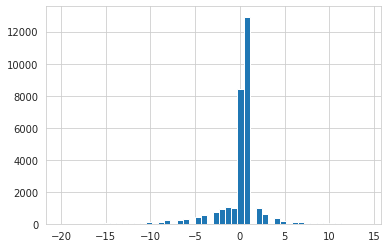

In [82]:
n_epochs = 60

for batch in dataloader_abide_both:
    break
plt.hist(batch.edge_attr.flatten().tolist(), bins=50)
plt.show()

In [83]:
net = NetWithReadout(num_features=batch.x.shape[1], num_classes=num_classes, hidden=64).to(device)
history_loss_baseline, history_acc_baseline = train_model(net, 
                                                          dataloader_abide_train,
                                                          n_epochs=n_epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [84]:
curv_net = NetСurvWithReadout(num_features=batch.x.shape[1], num_classes=num_classes, edge_dim=batch.edge_attr.shape[1], hidden=64).to(device)
history_loss_curv, history_acc_curv = train_model(curv_net, 
                                                  dataloader_abide_train,
                                                  n_epochs=n_epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [85]:
history_loss_baseline_val, history_acc_baseline_val = validate_model(net,
                                                                     dataloader_abide_val)
history_loss_curv_val, history_acc_curv_val = validate_model(curv_net,
                                                              dataloader_abide_val)

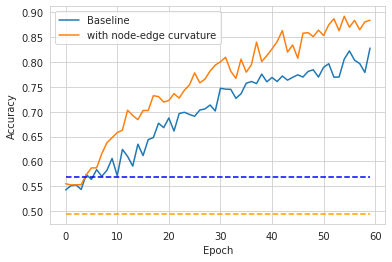

In [86]:

plt.plot(history_acc_baseline['epoch'], label='Baseline')
plt.plot(history_acc_curv['epoch'], label='with node-edge curvature')

plt.plot([history_acc_baseline_val]*n_epochs, '--', color='blue')
plt.plot([history_acc_curv_val]*n_epochs, '--', color='orange')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

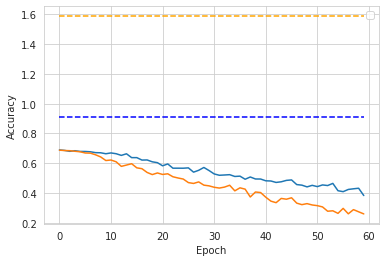

In [87]:
plt.plot(history_loss_baseline['epoch'])
plt.plot(history_loss_curv['epoch'])

plt.plot([history_loss_baseline_val]*n_epochs, '--', color='blue')
plt.plot([history_loss_curv_val]*n_epochs, '--', color='orange')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()